# Sobol Option Pricing

In this notebook, we demonstrate how to use the C++ sobol random number generator in the process of pricing call options.

We compare a number of methods for pricing **Asian** and **European** call options, using both [Black Scholes](#BS) and [Monte Carlo](#MC) techniques. In the case of Monte Carlo, option prices are generated using the following combinations of methods:
- **Random** number generation with **Standard** approximation.
- **Sobol** number generation with **Standard** approximation.
- **Sobol** number generation with **Brownian Bridge** approximation.

The Black Scholes function for each market produces a closed form solution with a deterministic result, while the Monte Carlo functions perform a number of random experiments and return an average price, based on the option type and the strike price.

In the final [example](#Example), the **RMSE** is calculated between the Monte Carlo and Black Scholes prices. The process is repeated for an increasing number of paths, with resulting errors compared.

---

### Requirements

The functions used throughout this notebook require the following packages to be installed:
- Sobol C++ library
- matplotlib

---

### Load q scripts

We start by loading q scripts which contain wrappers for the C++ random and sobol sequence number generators, along with the functions required to produce both cumulative and inverse cumulative normal distributions.

Graphics functions used throughout this notebook have also been loaded in.

In [1]:
\c 20 70
\l ../code/q/norm.q
\l ../code/q/rand.q
\l graphics/graphics.q

---

<a id='BS'></a>
## Black Scholes Option Pricing

One method used to calculate option prices is the Black Scholes formula, derived from the [Black Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). In this notebook, we look at the Black Scholes methods for both Asian and European call options. The function for each market produces a closed form solution with a deterministic result.

For European call options, the price of the corresponding option at time $t$, $P(S_{t},t)$, is given by:

$$\begin{eqnarray}
d_{1} = \frac{1}{\sigma\sqrt{T-t}}\Big[ln\Big(\frac{S_{t}}{K}\Big)+\Big((r-q)+\frac{\sigma^{2}}{2}\Big)(T-t)\Big]
\end{eqnarray}$$

$$\begin{eqnarray}
d_{2} = d_{1}-\sigma\sqrt{T-t}
\end{eqnarray}$$

$$\begin{eqnarray}
P(S_{t},t) = S_{t}e^{-q(T-t)}N(d_{1})-Ke^{-r(T-t)}N(d_{2})
\end{eqnarray}$$

Where $T$ is the expiry, $S_{t}$ is the price of the underlying asset at time $t$, $K$ is the strike price of the option, $\sigma$ is the volatility and $r$ is the interest rate. Note that the price is discounted by the dividends, $q$, throughout. [[1](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)]

For Asian call options, we implement the same formula, using an adjusted $S_{t}$ and $\sigma^{2}$:

$$\begin{eqnarray}
\mu_{adj} = \frac{1}{2}\Big(r-\frac{\sigma}{2}\Big)\Big(1+\frac{1}{n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
\sigma^{2}_{adj} = \frac{\sigma^2}{3}\Big(1+\frac{1}{n}\Big)\Big(1+\frac{1}{2n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
{S_{t}}_{adj} = S_{t}e^{\frac{1}{2}\sigma^{2}_{adj}(T-t)+\mu_{adj}-r}
\end{eqnarray}$$

Where $n$ is the number of timesteps.

The Black Scholes function for each option type are written in q below.

In [2]:
/ Black Scholes - European
bsEuroCall:{[pd]
 d1:(log[pd[`s]%pd`k]+t*(pd[`r]-pd`q)+.5*v*v)%vrtt:(v:pd`v)*sqrt t:pd`t;
 (pd[`s]*exp[neg t*pd`q]*cnorm1 d1)-pd[`k]*exp[neg t*pd`r]*cnorm1 d1-vrtt}

/ Black Scholes - Asian
bsAsiaCall:{[n;pd]
 adjmu:.5*((r:pd`r)-.5*v2:v*v:pd`v)*n1:1+1.%n;
 adjv2:(v2%3)*n1*1+.5%n;
 adjS :pd[`s]*exp(t:pd`t)*(hv2:.5*adjv2)+adjmu-r;
 d1:(log[adjS%k:pd`k]+t*(r-q:pd`q)+hv2)%rtv2:sqrt adjv2*t;
 (adjS*exp[neg q*t]*cnorm1 d1)-k*exp[neg r*t]*cnorm1 d1-rtv2}

We can see the output of both functions below. The required parameters, listed below, must be specified in a dictionary prior to use.
- `s` - Asset price at $t=0$
- `k` - Strike
- `v` - Volatility
- `r` - Interest rate
- `q` - Dividends
- `t` - Expiry

Note that the Black Scholes price of an Asian call option is also dependent on the number of timesteps `n`.

In [3]:
nsteps:500
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1
-1"European Black Scholes Price: ",string bseuro:bsEuroCall pd;
-1"Asian Black Scholes Price: ",string bsasia:bsAsiaCall[nsteps]pd;

European Black Scholes Price: 10.45058
Asian Black Scholes Price: 5.55623


---

<a id='MC'></a>
## Monte Carlo Experiments

In order to generate option prices using Monte Carlo methods, a number of experiments must be performed. In each experiment, we:
1. Randomly generate a number n, `nSteps`, of numbers (random or sobol).
2. Convert into a normal distribution using `invcnorm`.
3. Convert into a Wiener path random walk using standard or Brownian bridge approximation.
4. Convert into an asset price path based on parameters `s`, `v`, `r`, `q` and `t`.
5. Convert into an option price based on the option type and strike price, `k`.

The prices produced are then averaged to get a final predicted price.

Below we demonstrate the process for a sobol sequence paired with Brownian bridge approximation.

### 1. Random number generation

In the example below, 500 random numbers are generated for both random and sobol sequences, with results plotted for comparison.

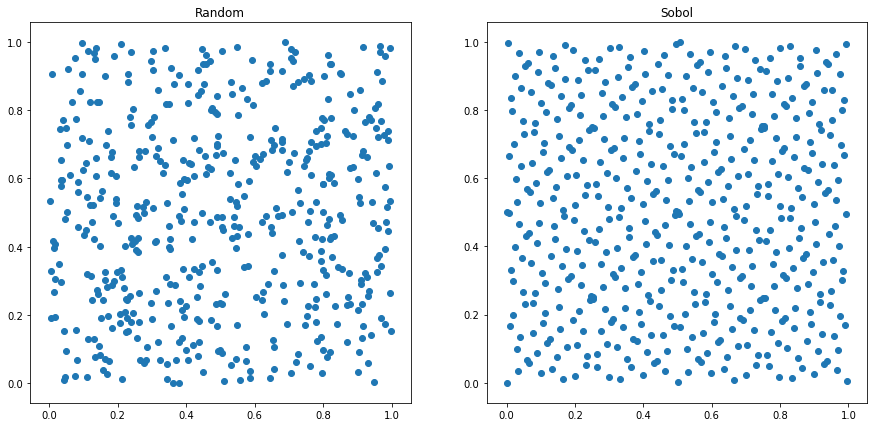

In [4]:
\S 20
rdm:(2;nsteps)#mtrand3 2*nsteps
sob:flip sobolrand each nsteps#2
subplot[rdm;sob;"Random";"Sobol"]

We see that the uniform random numbers do not actually look "random". Points tend to cluster together in some sections, while leaving large portions of white space in others. 

In contrast, the sobol example exhibits points are better spaced out, with few points clumping together. This seems like a more realistic representation of a truly random sequence of numbers.

### 2. Convert to a Gaussian Distribution

The generated sequences are then converted from a uniform distribution to a gaussian distribution. Following this conversion around 68% of the values lie within one standard deviation, while two standard deviations account for around 95% and three account for 99.7%. [[2](https://en.wikipedia.org/wiki/Normal_distribution)]

<img src="graphics/gaussian.png" style="height:400px">

<u><b><center>Gaussian Distribution</center></b></u>

Below we demonstrate how to convert the uniform distribution for the generated sobol sequence to a normal distribution using the inverse cumulative normal function, `invcnorm`.

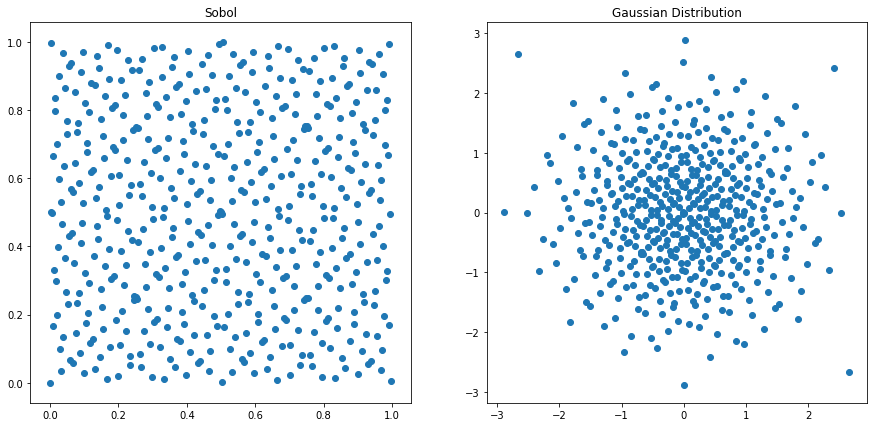

In [5]:
zsob:invcnorm each sob
subplot[sob;zsob;"Sobol";"Gaussian Distribution"]

The plots show that the distributions have been converted such that around 95% of the data now lies within 2 standard deviations of the centre.

### 3. Convert into a Wiener path random walk

The next step in the Monte Carlo pricing method is to create a random walk with discrete values and n steps (equal to the number of timesteps). In the standard approximation, this can be found by taking the cumulative sum across the values in the gaussian distribution.

For the Brownian bridge approximation, we first need to find the order of steps in the Wiener path. The overall idea is to create a path with n timesteps (from 0 to n-1) where we want to calculate the last step first, followed by the mid-step and then fill in the rest.

The process is as follows:
1. Start by calculating the first and last steps, where we assume that the first index has a value equal to 0.
2. Calculate the mid-step, noting that for floating point values we round down.
3. Then follow an iterative bisecting process (see note below):
    1. Start with the current mid-point.
    2. Move to the right, to the next index which is already in the path.
    3. Find the mid-point between that index and the index to its right.
    4. Move to the new mid-point.
4. This process of moving to the right and finding the mid-point between indices is then repeated until there are no further indices left to add to the path.

<div class="alert alert-danger">
<b>Note:</b>

1. The sequence acts as a loop, such that moving to point n is equivalent to index 0.

2. It is only possible to move between steps which have already been added to the final path.
</div>

An example of building up a Brownian bridge is shown in the diagram below, where we have a total of 15 timesteps (from 0 to 14).

<img src="graphics/bbconstruct.png">

<b><u><center>The construction of a Brownian bridge over 14 steps</center></u></b>
<i><center>Jäckel P. Monte Carlo Methods In Finance. Chichester: J. Wiley; 2002.</center></i>

The q code to build both a Brownian bridge and Wiener path random walk are shown below.

In [6]:
/ Build a Brownian bridge
bbridge:{[n;dt]
 bb:first flip(n-1).[i.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
 bb:update lwt:bidx-lidx,rwt:ridx-bidx,sigma:ridx-lidx from bb;
 bb:update lwt%sigma,rwt%sigma,sigma:sqrt dt*lwt*rwt%sigma from bb;
 i.buildpath .[bb;(0;`sigma);:;sqrt n*dt]}

/ Create Wiener path
wpath:{[n;d]$[(::)~d`bb;sums;d`bb]invcnorm$[d`sobol;sobolrand;mtrand3]n}

/ Create an initial Brownian bridge
i.initbb:{[n;d;m]
 if[n<=j:1+d`ridx;j:0];
 d:`bidx`ridx`lidx!(l:j+(k-j+1)div 2;k:j+first where j _m;-1+j+:first where not j _m);
 (d;@[m;l;:;1b])}

/ Create a path to follow
i.buildpath:{[bb;z]if[count[z]<>n:count bb;'`length];
 {[x;bb;z]@[x;bb`bidx;:;z+(x[bb`ridx]*bb`rwt)+$[0>l:bb`lidx;0;x[l]*bb`lwt]]
  }/[((n-1)#0.),first z*:bb`sigma;1_bb;1_z]} 

We can demonstrate how the Brownian bridge is built using the code below, which will output a table with n timesteps (in this case n = 6), showing the order in which steps are added to the path.

In [7]:
bbdemo:{[n;dt]
  x:enlist[(n+1)#0b],1b,'enlist[n#0b],last flip(n-1).[i.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
  bbd::"\n"vs .Q.s flip(`$"i",'string til count x)!x:flip(" X")x;}
.z.ts:{if[2<count bbd;-1 system"clear";-1@'3#bbd;bbd::(2#bbd),3_bbd];}

In [8]:
\t 1000
bbdemo[5;1.]


i0 i1 i2 i3 i4 i5
-----------------
                 

i0 i1 i2 i3 i4 i5
-----------------
X                

i0 i1 i2 i3 i4 i5
-----------------
X              X 

i0 i1 i2 i3 i4 i5
-----------------
X     X        X 

i0 i1 i2 i3 i4 i5
-----------------
X  X  X        X 

i0 i1 i2 i3 i4 i5
-----------------
X  X  X  X     X 

i0 i1 i2 i3 i4 i5
-----------------
X  X  X  X  X  X 

i0 i1 i2 i3 i4 i5
-----------------



When recording the order of steps in the path, we also take note of the left and right weights and indices, and the corresponding sigma value for each step in the sequence. Below we show this for 500 timesteps and 1 unit of time.

In [9]:
dt:1
last value bbex:bbridge[nsteps;dt]

bidx ridx lidx lwt       rwt       sigma   
-------------------------------------------
499  499  499                      22.36068
249  499  -1   0.5       0.5       11.18034
124  249  -1   0.5       0.5       7.905694
374  499  249  0.5       0.5       7.905694
61   124  -1   0.496     0.504     5.589991
186  249  124  0.496     0.504     5.589991
311  374  249  0.496     0.504     5.589991
436  499  374  0.496     0.504     5.589991
30   61   -1   0.5       0.5       3.937004
92   124  61   0.4920635 0.5079365 3.968127
155  186  124  0.5       0.5       3.937004
217  249  186  0.4920635 0.5079365 3.968127
280  311  249  0.5       0.5       3.937004
342  374  311  0.4920635 0.5079365 3.968127
405  436  374  0.5       0.5       3.937004
..


Bringing everything together, we can calculate the Wiener path random walk for a sobol sequence with 500 timesteps using the Brownian bridge constructed in the previous cell. Note that the function `wpath` takes the following arguments:
- `n` - Number of timesteps.
- `d` - Dictionary indicating whether to use Brownian bridge or standard approximation and sobol (`1b`) or random (`0b`) number generation. If using Brownian bridge, the initial Brownian bridge must be passed in, if not, `(::)` must be used.

-0.4026676 -0.9855094 0.9992106 2.577225 0.3727821 -0.1956406 0.05106515 0.01925348 -1.890848 -2.885893 -1...


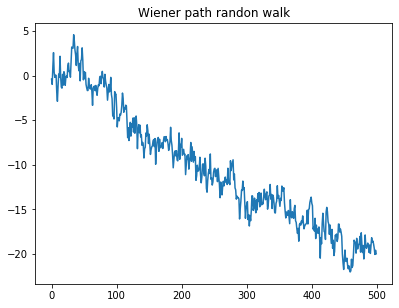

In [10]:
\c 200 110
d:`bb`sobol!(bbex;1b)
show w:wpath[nsteps;d]
plt[`:title]"Wiener path randon walk";
plt[`:plot]w;
plt[`:show][];

### 4. Convert into asset price path

At this point it is possible to convert the Wiener path to an asset price path using the function below.

In [11]:
spath:{[n;d;pd]pd[`s]*exp(wpath[n;d]*pd[`v]*sqrt dt)+(1+til n)*dr:(pd[`r]-pd[`q]+.5*v*v:pd`v)*dt:pd[`t]%n}

Here we calculate and plot results for the asset price path for 500 timesteps, sobol number generation and Brownian bridge approximation.

99.70327 99.61439 99.07735 99.69772 100.454 100.6546 99.06416 99.07757 99.89278 100.3007 100.3108 99.61233 ..


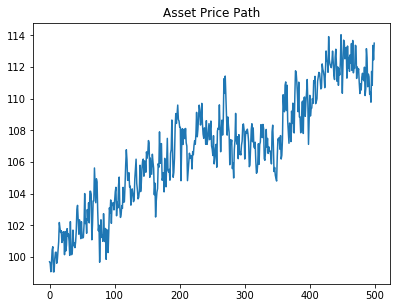

In [12]:
show s:spath[nsteps;d;pd]
plt[`:title]"Asset Price Path";
plt[`:plot]s;
plt[`:show][];

### 5. Convert into option price

Lastly, we average the asset price path to find a single price for the Monte Carlo method. This will allow us to compare the predicted price to the Black Scholes equivalent.

In [13]:
/ Monte Carlo prices for European call option
mcEuroCall:{[m;n;d;pd]exp[neg pd[`r]*pd`t]*avg 0|(last each spath[;d;pd]each m#n)-pd`k}

/ Monte Carlo prices for Asian call option
mcAsiaCall:{[m;n;d;pd]exp[neg pd[`r]*pd`t]*avg 0|(last each prds each xexp[;1%n]spath[;d;pd]each m#n)-pd`k}

For 500 timesteps we get the following results.

In [14]:
npaths:10
-1"European Monte Carlo Price: ",string mcEuroCall[npaths;nsteps;`bb`sobol!(bbex;1b);pd];
-1"Asian Monte Carlo Price: ",string mcAsiaCall[npaths;nsteps;`bb`sobol!(bbex;1b);pd];

European Monte Carlo Price: 17.40977
Asian Monte Carlo Price: 3.090907


---

<a id='Example'></a>
## Example

In this section we deploy all of the aforementioned techniques and compare the results.

#### Parameters

First we need to create a dictionary of parameters as shown previously.

In [15]:
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1

We also need to initialize the number of paths (experiments), steps and trials.

In [16]:
l:20           / Number of trials
m:8+64*til 16  / Number of paths
n:1000         / Number of steps

Given that the initial Brownian bridge will be the same throughout, it can also be initialized and passed in as an argument.

In [17]:
bb:bbridge[n;1]

#### Run experiments
The below functions will calculate the RMSE between the Black Scholes and Monte Carlo prices for each market and each Monte Carlo technique.

In [18]:
/ Run all techniques for option pricing
runall:{[bb;pd;l;n;m]
 st:.z.p;bseuro:bsEuroCall pd;
 e:i.run[`euro;bseuro;bb;pd;l;n]each m;
 -1"European: time taken = ",string .z.p-st;
 st:.z.p;bsasia:bsAsiaCall[n;pd];
 a:i.run[`asia;bsasia;bb;pd;l;n]each m;
 -1"Asian:    time taken = ",string .z.p-st;
 e,a}

/ Show individual results tables
rt:{[t;m]show delete mkt from select from t where mkt=m}

i.d:`bb`sobol!
i.rcol:`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`bsprx
i.rmse:{sqrt avg x*x-:y}
i.run :{[mkt;bs;bb;pd;l;n;m]
 mc:$[mkt~`asia;mcAsiaCall;mcEuroCall][;n;;pd];
 ea:i.rmse[bs]a:mc[;i.d(bb;1b)]each k:l#m;
 eb:i.rmse[bs]mc[;i.d(::;1b)]each k;
 ec:i.rmse[bs]mc[;i.d(bb;0b)]each k;
 i.rcol!(mkt;m;ea;eb;ec;last a;bs)}

In [19]:
\c 200 110
r:runall[bb;pd;l;n;m]
-1"\nEuropean:";rt[r;`euro]
-1"\nAsian:";rt[r;`asia]

European: time taken = 0D00:03:47.386280000
Asian:    time taken = 0D00:04:07.443480000

European:
npaths rmse_bb_sobol rmse_std_sobol rmse_std_rdm prx_bb_sobol bsprx   
----------------------------------------------------------------------
8      1.794644      3.837561       2.94143      8.378523     10.45058
72     0.3128106     1.031527       1.853865     10.17968     10.45058
136    0.1820502     0.815297       1.354513     10.29831     10.45058
200    0.1195803     0.3914747      1.217619     10.35758     10.45058
264    0.1005539     0.5686765      0.718586     10.43661     10.45058
328    0.09157963    0.3943636      0.918205     10.3857      10.45058
392    0.0786071     0.4311004      0.5562456    10.46233     10.45058
456    0.06334232    0.3945352      0.7960273    10.56963     10.45058
520    0.0395094     0.4623517      0.6315791    10.43022     10.45058
584    0.05810144    0.3569778      0.664507     10.36428     10.45058
648    0.05220983    0.3793464      0.5062635    

#### Compare results

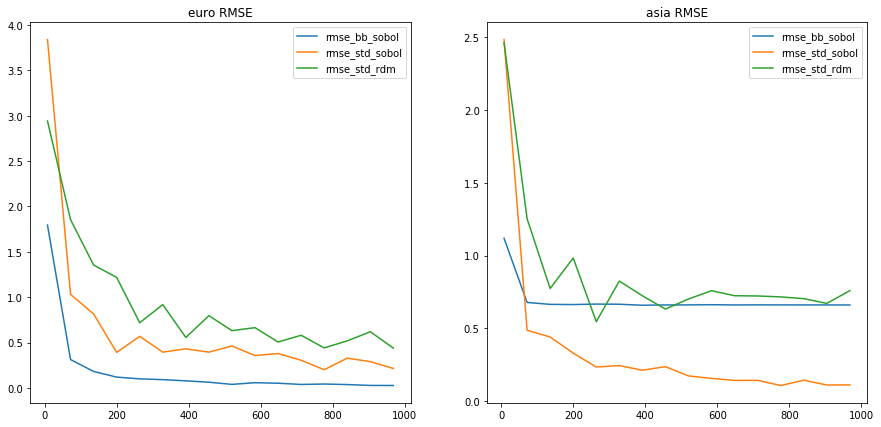

In [20]:
rmseplot[r]

---

## Conclusion

We have shown that it is possible to calculate option prices using both Black Scholes and Monte Carlo methods. The Monte Carlo methods deploy different implementations of Wiener path approximation and random number generation.

Looking at the results above, it is clear that the RMSE produced between the predicted Monte Carlo price and Black Scholes price converges fastest by using either Brownian bridge approximation and/or sobol sequences.

---